<h1 align="center">AIND-Engineering Hackathon</h1>  
<h4 align="center"> July 24, 2025 </h4>   
<h4 align="center"> Credit Assignment During Learning</h4> 
<h4 align="center"> Author: Su Yee Lee</h4> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
**Overview:** In this notebook, we will analyze neural activity and connectivity changes 
during learning using a dataset from the [Credit Assignment During Learning](https://www.allenneuraldynamics.org/projects/credit-assignment-during-learning) 
project at the Allen Institute for Neural Dynamics. This dataset provides a unique window 
into how cortical circuits adapt as mice learn to volitionally control a brain-computer interface (BCI) 
using single neurons in motor cortex. This tutorial focuses on population activity and event-aligned responses
in one experimental paradigm, multi-day learning, longitudinal connectivity mapping, 
and causal perturbations across many animals.
 
**Dataset:** 
Neural activity was recorded from layer 2/3 excitatory neurons in the primary motor cortex 
of head-fixed mice using two-photon calcium imaging. Imaging was performed over multiple days
 as each animal learned and performed a BCI task. Each day, a new conditioned neuron (CN) was selected, 
 the activity of this neuron was mapped in real-time to the position of a motorized reward port. 
 To receive water rewards, mice had to learn to increase the activity of the CN to move the port into reach.
The dataset also includes simultaneous photostimulation and calcium imaging sessions, in which individual or 
groups of neurons were optogenetically stimulated to assess their causal influence on the surrounding network. 
These connection mapping sessions were repeated daily to measure how connectivity changed as learning progressed.
 Imaging data were preprocessed using Suite2p and include motion-corrected fluorescence traces, 
 extracted ROIs, inferred spiking events, and stimulus-aligned behavioral metadata. 
 All data are registered across days to track the same neurons longitudinally.

 **Experiment:**
 This experiment was designed to test competing models of learning rules—such as Hebbian learning, 
 long-range input modulation, and biologically plausible approximations of error backpropagation—by 
 directly measuring changes in neural activity and inferred connectivity during learning. 
 The core task involved a closed-loop BCI paradigm in which a single neuron’s activity controlled 
 a reward mechanism. Because the mapping from activity to behavior was fully defined by the experimenter,
  this paradigm enables ground-truth labeling of neurons as behaviorally causal (e.g., the CN) versus merely correlated.
To probe learning-related circuit changes, cellular-resolution two-photon photostimulation
 was used to perturb neurons before and after learning. By analyzing evoked responses, 
 researchers could infer the presence and strength of functional connections. 
 Learning-induced changes in connectivity were then compared to predictions 
 from recurrent neural network models trained with different plasticity rules, 
 enabling discrimination between competing learning algorithms.
    
**Goal:** This tutorial will show you how to: <br> 
    1. Load and explore calcium imaging data processed with Suite2p <br> 
    2. Align neural activity to behavioral events in the BCI task <br>
    3. Visualize trial-averaged activity of the conditioned neuron and surrounding population <br> 
    4. Prepare data for analyses of population-level changes during learning <br> 



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Import packages and load data

In [31]:
# General imports 
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import os 
import re
import pandas as pd
from skimage import measure
from pathlib import Path

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Metadata

The 'metadata.csv' in the '/data' folder contains relevant information about the experimental session and the subject. 

| Column    | Description |
| -------- | ------- |
| id | data asset id |
| name | filename of data asset (raw) |
| subject_id| numerical id for animal subject  |
| session_time |  experiment date (%Y-%m-%d %H:%M:%S)   |
| session_type   |  experiment identifier  |
| genotype  | subject genotype   |
| virus   | injected virus type  |
| ophys_fov   | field of view identifier  |
| session_number    | behavior training session number   |

In [32]:
# Load csv as a Pandas DataFrame 
metadata = pd.read_csv('/data/metadata.csv', index_col = False) 

# Sort values by name and reindex 
metadata = metadata.sort_values(by = ['name']).reset_index(drop = True)
metadata.head()

,_id,name,subject_id,session_time,session_type,genotype,virus_injection_materials,ophys_fov,session_number
0,4fcfc173-452d-4d5b-b441-7b26da3d781b,single-plane-ophys_731015_2025-01-24_20-00-44_...,731015,2025-01-24T18:41:22.550000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,20.0
1,1f1039a9-72a2-4dd0-880b-2fe06c64e96a,single-plane-ophys_731015_2025-01-28_17-40-57_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
2,b46c42e9-b7cc-4a1e-832d-9721816c9bc5,single-plane-ophys_731015_2025-01-28_18-56-35_...,731015,2025-01-28T17:40:57.996000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,22.0
3,b2497fb0-0e67-4c9a-b543-76ccc2c7fdbd,single-plane-ophys_731015_2025-01-31_20-37-19_...,731015,2025-01-31T20:37:19.623000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_04,23.0
4,069e10c0-6d10-4101-bc33-f3febf0a6565,single-plane-ophys_740369_2025-01-09_17-18-37_...,740369,2025-01-09T16:01:04.455000-08:00,BCI single neuron stim,Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-IC...,pAAV-hSyn1-RiboL1-GCaMP8s-WPRE,FOV_05,22.0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This file was pre-generated by running the metadata python notebook attached to this capsule. More metadata was captured for each experimental session than what is shown here - you can access the full records by querying the AIND metadata database using `aind-data-access-api`. See the metadata python notebook for an example. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Data Organization 
    
The naming scheme for each raw data asset is as follows:
 > single-plane-ophys (data type) <br> 
   772414 (numerical id for the subject) <br> 
   2025-01-10T16:46:51.981999-08:00 (experiment date (%Y-%m-%d %H:%M:%S)) <br>
    
The /data folder contains a directory named for each experimental session that was processed through the optical physiology (ophys) pipeline (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_processed_2025-05-07_12-19-25`). The pipeline runs the raw fluorescence data through suite2p and packages the ophys, behavior, and stimulus information into an Neurodata Without Borders (NWB) format. Each directory contains an NWB directory (e.g. `single-plane-ophys_731015_2025-01-24_20-00-44_behavior_nwb`).
    
From the metadata table, we'll store the subject_id and date for a session of interest. 

In [33]:
idx = 10

subject_id = metadata.subject_id[idx] 
subject_id = '731015'
date = metadata.session_time[3][0:10] # save just the year, month, and date
print(subject_id, date)

731015 2025-01-31


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Load Data 
    
These NWB files are stored in a cloud-friendly Zarr backend. We'll use the NWBZarrIO package from hdmf_zarr to load the files. 
    
We've written a helper function `load_nwb` that searches the /data folder for an NWB directory that matches a given subject_id and date, then loads using NWBZarrIO. 
    

In [34]:
# to do - simplify this loading function 
def load_nwb(subject_id, date):
    """
    Searches the /data directory for a folder and subfolder containing the subject_id and date,
    and loads the corresponding NWB file.

    Parameters:
    - subject_id (str): Subject identifier to search for in directory names
    - date (str): Date string (e.g. '2023-05-09') to search for in directory names

    Returns:
    - nwbfile: Loaded NWBFile object if found, else None
    """

    # Create pattern for matching
    pattern = rf".*{subject_id}.*{date}.*"
    base_path = Path('/data')
    
    # Find matching first-level directories
    first_matches = [d for d in base_path.iterdir() 
                     if d.is_dir() and re.search(pattern, d.name)]
    
    if not first_matches:
        print(f"Directory matching subject_id={subject_id} and date={date} not found in /data.")
        return None
    
    first_dir = first_matches[0]
    print(f"Found first-level directory: {first_dir.name}")
    
    # Find matching second-level directories
    second_matches = [d for d in first_dir.iterdir() 
                      if d.is_dir() and re.search(pattern, d.name)]
    
    if not second_matches:
        print(f"No second-level directory matching subject_id={subject_id} and date={date} found.")
        return None
    
    nwb_path = second_matches[0]
    print(f"Found second-level directory: {nwb_path.name}")
    
    # Check if path exists and load NWB file
    try:
        with NWBZarrIO(str(nwb_path), 'r') as io:
            nwbfile = io.read()
            print('Loaded NWB file from:', nwb_path)
            return nwbfile
    except Exception as e:
        print(f'Error loading file from {nwb_path}: {e}')
        return None

In [ ]:
# simplify and make into an exercise (load NWB file)

In [35]:
nwbfile = load_nwb(subject_id, date)

Found first-level directory: single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-07-23_02-28-40
Found second-level directory: single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Loaded NWB file from: /data/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-07-23_02-28-40/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

`nwb2widget` creates an interactive widget to easily explore the hierarchical contents of the NWB file. The widget can also render interactive data plots (e.g. calcium activity traces, image segmentation masks). 

In [36]:
nwb2widget(nwbfile) 


In [37]:
nwbfile

root pynwb.file.NWBFile at 0x140595934543488
Fields:
  devices: {
    442_Bergamo_2p_photostim <class 'pynwb.device.Device'>
  }
  epochs: epochs <class 'pynwb.epoch.TimeIntervals'>
  file_create_date: [datetime.datetime(2025, 7, 22, 19, 36, 52, 330369, tzinfo=tzutc())]
  identifier: b02606e9-cd4d-467c-b780-60999e7a3115
  imaging_planes: {
    processed <class 'pynwb.ophys.ImagingPlane'>
  }
  institution: Allen Institute for Neural Dynamics
  intervals: {
    epochs <class 'pynwb.epoch.TimeIntervals'>
  }
  processing: {
    processed <class 'pynwb.base.ProcessingModule'>
  }
  session_description: NWB file generated by AIND pipeline
  session_id: single-plane-ophys_731015_2025-01-31_20-37-19
  session_start_time: 2025-01-31 20:37:19-08:00
  stimulus: {
    PhotostimTrials <class 'hdmf.common.table.DynamicTable'>,
    Trials <class 'hdmf.common.table.DynamicTable'>
  }
  subject: subject pynwb.file.Subject at 0x140595932599664
Fields:
  age: P323D
  age__reference: birth
  date_of_birth: 2024-03-14 00:00:00-07:53
  genotype: Slc17a6-IRES-Cre/wt;Ai230(TIT2L-XCaMPG-WPRE-ICL-ChRmine-oScarlet-IRES2-tTA2-WPRE)-hyg/wt
  sex: F
  species: Mus musculus
  subject_id: 731015

  timestamps_reference_time: 2025-01-31 20:37:19-08:00

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot Calcium Activity Traces for Select ROIs 
    
The raw fluorescence data was processed through suite2p, which segments the images into ROIS for detected neurons and calculates the change in fluorescence (dff) for each ROI. Let's store the dff data from the NWB file below. The shape of dff is nframes x nrois. 
    
We'll also store the frame_rate to easily convert from frames to seconds.
    

In [87]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data
dff.shape


(249370, 1736)

In [38]:
dff = nwbfile.processing["processed"].data_interfaces["dff"].roi_response_series["dff"].data

print('dff shape (nframes, nrois):',np.shape(dff))

frame_rate = nwbfile.imaging_planes["processed"].imaging_rate
print('Frame Rate:', frame_rate)

dff shape (nframes, nrois): (249370, 1736)
Frame Rate: 58.2634


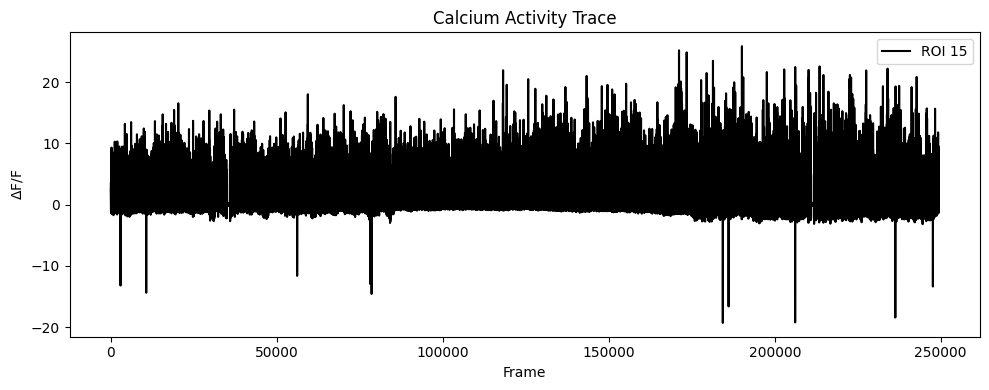

In [63]:
# Select an ROI 
ROI = 15

# Figure parameters 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Experiment Structure 
    
The dff array covers the entire experimental period, which has 5 experimental epochs. 

    1. Photostimulation of single neurons * 
    2. Spontaneous activity *
    3. BCI behavior task 
    4. Spontaneous activity * 
    5. Photostimulation of single neurons * 
    
*In some cases, the spontaneous epoch happens before the photostimulation period. Check the stimulus tables for each data file to get the exact timing order of each epoch. 

The NWB file contains information about the stimulus and the behavior trials.  


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Epoch Table 
    
The epochs table contains the start and stop times/frames for each experimental epoch, so we can easily pull these values for later use. 


In [64]:
epoch_table = nwbfile.intervals["epochs"].to_dataframe()
epoch_table

,stimulus_name,start_frame,stop_frame,start_time,stop_time
id,,,,,
0,photostim,0,84794,0.000000,1455.356193
1,spont,84795,90794,1455.373356,1558.336795
2,spont_again,90795,98594,1558.353958,1692.211577
3,BCI,98595,160009,1692.228741,2746.303855
4,spontpost,160010,175538,2746.321018,3012.834816
5,photostim_post,175539,249369,3012.851979,4280.028285


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Stimulus table (2p optogenetic activation stimulus) 
    
The stimulus table (stimulus > PhotostimTrials) contains information about each 2p optogenetic stimulation trial. 

| Column    | Description |
| -------- | ------- |
| start_time  | stimulus start (s)  |
| stop_time | stimulus end (s)   |
| start_frame | stimulus start (frame)     |
| stop_frame    | stimulus end (frame)  |
| tiff_file   | data source file name  |
| stimulus_name    | stimulus name   |
| laser_x    | x coordinate of stimulated neuron (pixel)   |
| laser_y    | y coordinate of stimulated neuron (pixel)  |
| power    | stimulus intensity (mW)  |
| duration    | trial duration (s)  |
| stimulus_function    | stimulus template   |
| group_index    | identity of stimulated neuron(s)   |
| closest_roi    | index in dff that corresponds to the photostimulated neuron   |


In [65]:
photostim = nwbfile.stimulus["PhotostimTrials"].to_dataframe()
photostim.head()


,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.583557,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,15,85


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are two photostimulation epochs - one before and one after the BCI epoch. This is distinguished by the "stimulus_name" column. 

In [66]:
photostim["stimulus_name"].unique().tolist()

['photostim', 'photostim_post']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### BCI Behavior Table 
    
Information about the BCI behavior trials can be found in the intervals > trials table. 

| Column    | Description |
| -------- | ------- |
| start_time  | trial start (s)  |
| stop_time | trial end (s)   |
| go_cue |  time of go cue relative to start time (s)   |
| hit   |  boolean of whether trial was hit   |
| lick_l  | lick times (s)   |
| reward_time   | reward delivery time (s)   |
| threshold_crossing_times    | time when reward port crossed position threshold (s)   |
| zaber_steps_times   | position of reward port  |
| tiff_file    | data source file  |
| start_frame    | trial start (frame)  |
| stop_frame    | trial end (frame)  |
| conditioned_neuron_x    | coordinate for conditioned neuron (pixels)  |
| conditioned_neuron_y    | coordinate for conditioned neuron (pixels)  |
| closest_roi    | index in dff that corresponds to the photostimulated neuron  |


In [67]:
bci = nwbfile.stimulus["Trials"].to_dataframe()
bci.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot calcium activity for a select ROI with stimulus epochs overlaid. 


In [ ]:
# use photostim artifact as a group question / discussion - why are they there, how do you find them and deal with it

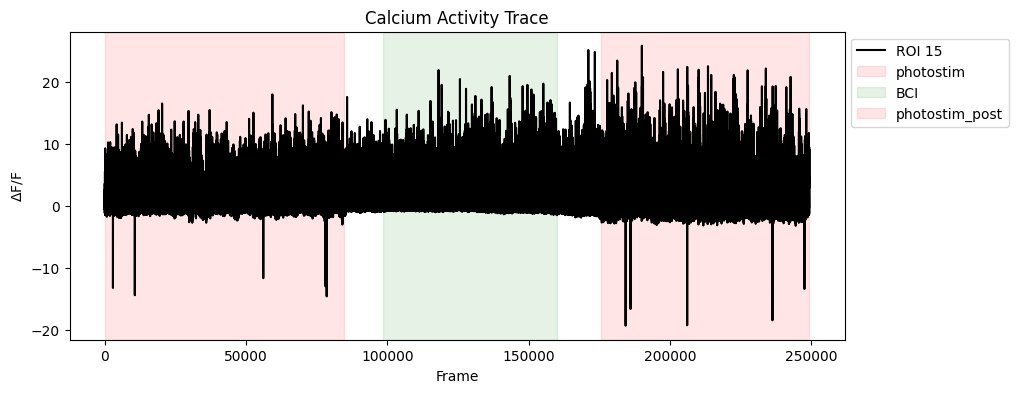

In [68]:
# Plot dff for select ROI 
plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Add shaded regions for stimulus epochs 
stimulus_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stimulus_name in enumerate(stimulus_names):
    stim = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stimulus_name)

plt.ylabel(r'$\Delta$F/F')
plt.xlabel('Frame')
plt.title('Calcium Activity Trace')
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Image Segmentation Table 
    
Each column in dff contains change in fluorescence activity for an extracted ROI. The raw fluorescence data is run through suite2p, which segments the image to extract image masks for each detected ROI. The suite2p outputs are run through additional soma and dendrite classifiers. Information about the spatial image masks and soma/dendrite can be found in the image segmentation table within the processing container. 
    
We'll store the image segmentation table as a Pandas DataFrame. 

| Column    | Description |
| -------- | ------- |
| is_soma  | ==1 if ROI classified as soma, ==0 if not  |
| soma_probability | if >0.5 classified as soma  |
| is_dendrite |  ==1 if ROI classified as dendrite, ==0 if not   |
| dendrite_probability   |  if >0.5 classified as dendrite  |
| image_mask  | HxW sparse array defining image masks|

In [69]:
image_segmentation = nwbfile.processing["processed"].data_interfaces["image_segmentation"].plane_segmentations["roi_table"].to_dataframe()
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### ROI Image Masks 
    
The image masks for each ROI are necessary for corresponding the ROIs to the photostimulated and conditioned neurons. If you recall, the photostim and bci tables report the centroid coordinates in pixel space for the photostimulated and conditioned neurons in each trial. 

Text(0.5, 1.0, 'ROI Image Mask')

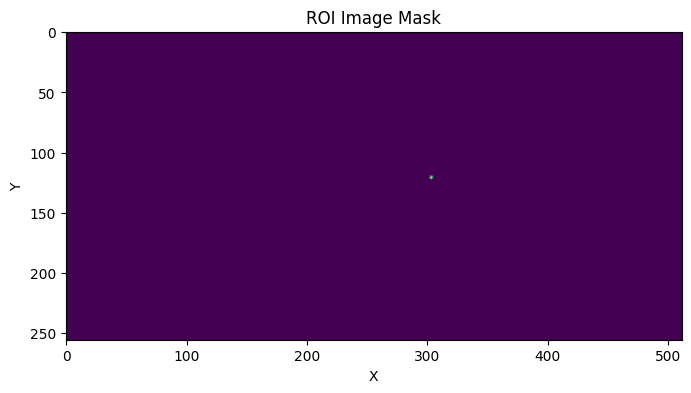

In [70]:
# Plot the image mask for selected ROI 
plt.imshow(image_segmentation.image_mask[ROI])
plt.xlabel('X') 
plt.ylabel('Y') 
plt.title('ROI Image Mask') 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot ROI DFF and Image Masks 
    
Building on our DFF frameseries plot, we'll add a plot indicating the spatial location of the selected ROI. Using image mask, we'll identify the contours of the ROI and overlay this with the average projection of the FOV image. 

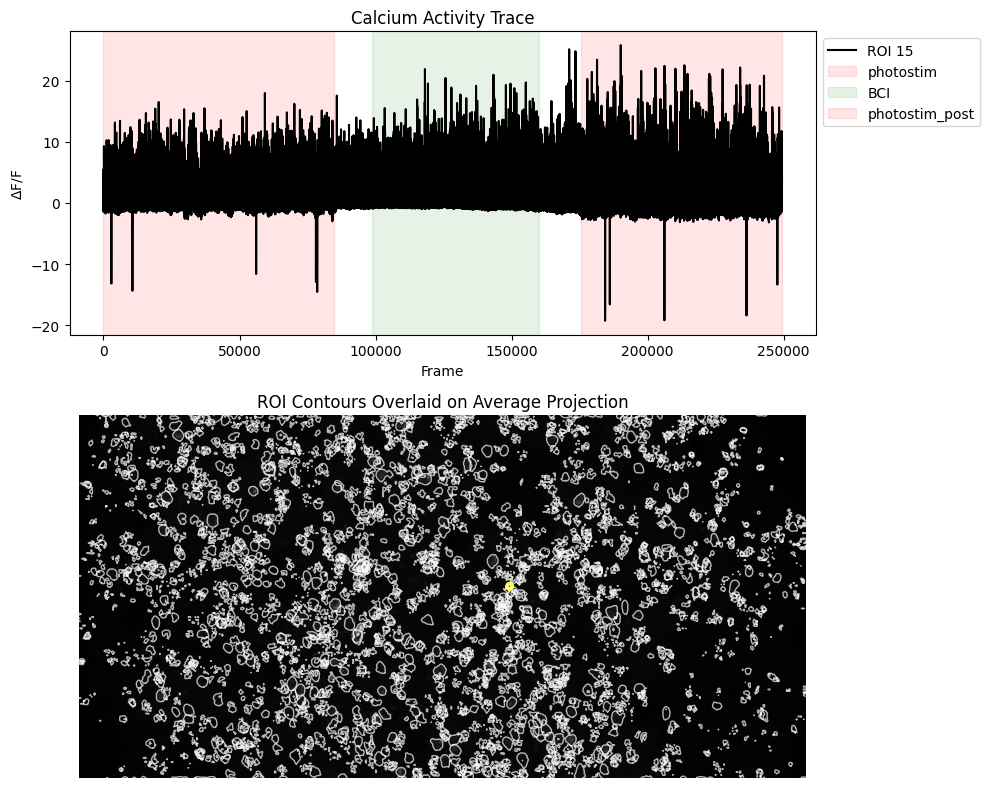

In [71]:
# FOV image data to underlay with image mask contours 
image = nwbfile.processing["processed"].data_interfaces["images"].images["average_projection"].data[:]  # shape: (H, W)

# Figure parameters for vertically stacked plots 
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), height_ratios=[1, 1.2])

# Top Plot: ROI DFF 
ax1.plot(dff[:, ROI], label=f'ROI {ROI}', color='black')

# Top Plot: Shaded regions for stimulus epochs 
stimulus_names = ['photostim','BCI','photostim_post']
colors = ['red','green','red']
for c,stimulus_name in enumerate(stimulus_names):
    stim = epoch_table[epoch_table.stimulus_name==stimulus_name]
    for j in range(len(stim)):
        ax1.axvspan(xmin=stim.start_frame.iloc[j], xmax=stim.stop_frame.iloc[j], color=colors[c], alpha=0.1, label = stimulus_name)

ax1.set_ylabel(r'$\Delta$F/F')
ax1.set_xlabel('Frame')
ax1.set_title('Calcium Activity Trace')
ax1.legend(bbox_to_anchor=(1.0, 1.0))

# Bottom plot: Grayscale image with ROI contours 
# Ensure proper display of the background image
ax2.imshow(image, cmap='gray', origin='upper', aspect='equal')
ax2.set_title('ROI Contours Overlaid on Average Projection')
ax2.axis('off')

# Overlay ROI contours
for i, mask in enumerate(image_segmentation.image_mask):
    mask_array = np.array(mask)
    # Find contours at a level that works well for binary masks
    contours = measure.find_contours(mask_array, level=0.5)
    
    for contour in contours:
        # Highlight the selected ROI
        if i == ROI:
            color = 'yellow'
            linewidth = 2.5
            alpha = 1.0
        else:
            color = 'white'
            linewidth = 1.0
            alpha = 0.7
        
        # Plot contour (note: contour coordinates are in (row, col) format)
        ax2.plot(contour[:, 1], contour[:, 0], color=color, linewidth=linewidth, alpha=alpha)

# Set the axis limits to match the image dimensions
ax2.set_xlim(0, image.shape[1])
ax2.set_ylim(image.shape[0], 0)  # Flip y-axis to match image coordinates

plt.tight_layout()
plt.show()

In [ ]:
# segmemtation discussion opportunity - how to filter / clean ; diff segmentation methods 

In [ ]:
# filter out non-cells, also need to filter dFF (make sure indexing doesnt give you problems)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
### Plot conditioned neuron activity aligned with behavior events. 
    
During the BCI behavior epoch, the activity of a single neuron (conditioned neuron) is used to control the movement of a reward lickport. Let's walk through how to plot the activity of the conditioned neuron aligned to the behavior trial start, lickport movements, and reward times. First, we need to take a detour and explain the x/y coordinates and the `closest_roi` columns in the bci table. Remember that `dff` is a nframes x nrois array that contains the change in fluorescence activity for each ROI extracted from the raw video. Which ROI in dff corresponds to the conditioned neuron? 

    
#### Matching the conditioned and photostimulated neurons to the post-hoc extracted ROIs 
In the bci table, note the `conditioned_neuron_x`, `conditioned_neuron_y` and `closest_roi` columns. During the BCI behavior epoch, a single neuron in the imaging FOV is selected for conditioning. This "conditioned neuron" is targeted using its x,y coordinates in the image pixel space, which gets stored as the `conditioned_neuron_x` and `conditioned_neuron_y` columns. When the raw data is processed, the calcium imaging videos are run through Suite2p and additional soma/dendrite classifiers, which extract ROIs for detected neuron somas. The ROIs are represented as image masks in the  `image_segmentation` table - sparse HxW arrays with non-zero values that fill the ROI area. If image segmentation is successful for the conditioned neuron, we can find the ROI image mask that is closest to the x/y coordinate used for targeting during the experiment. This calculation is done as part of the processing pipeline, but can be imperfect depending on the quality of image segmentation, so we'll walk through the steps below. 


In [72]:
bci.head()

,start_time,stop_time,go_cue,hit,lick_L,reward_time,threshold_crossing_times,zaber_step_times,tiff_file,start_frame,stop_frame,conditioned_neuron_x,conditioned_neuron_y,closest_roi
id,,,,,,,,,,,,,,
0,1692.228741,1704.020019,0.2359,True,"[1.7861, 1.9033, 2.0241, 2.1415, 2.2464, 2.375...",1.7861,1.7089,"[0.3535, 0.5054000000000001, 0.6074, 0.7184, 0...",neuron119_00001.tif,98595,99282,108.633333,51.666667,124
1,1704.037183,1708.722800,0.2359,True,"[1.0667, 1.2012, 1.3251000000000002, 1.4520000...",1.0667,1.0582,"[0.2869, 0.3589, 0.4188, 0.4969, 0.5359, 0.577...",neuron119_00002.tif,99283,99556,108.633333,51.666667,124
2,1708.739964,1714.060628,0.2359,True,"[0.7160000000000001, 0.8175, 0.9416, 1.0605, 1...",0.8175,0.7399,"[0.3182, 0.3502, 0.3822, 0.4142, 0.4462, 0.478...",neuron119_00003.tif,99557,99867,108.633333,51.666667,124
3,1714.077792,1718.488794,0.2359,True,"[1.0345, 1.1526, 1.2687000000000002, 1.392, 1....",1.0345,0.9577,"[0.4984, 0.5503, 0.5874, 0.6204000000000001, 0...",neuron119_00004.tif,99868,100125,108.633333,51.666667,124
4,1718.505957,1725.869070,0.2359,True,"[1.3371, 1.4519, 1.5667, 1.6952, 1.8063, 1.932...",1.3371,1.3072,"[0.8276, 0.8886000000000001, 0.9356, 0.9736, 1...",neuron119_00005.tif,100126,100555,108.633333,51.666667,124


In [85]:
len(image_segmentation)

1736

In [88]:
dff.shape

(249370, 1736)

In [73]:
image_segmentation.head()

,is_soma,soma_probability,is_dendrite,dendrite_probability,image_mask
id,,,,,
0,0,0.000019,0,0.144048,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,0.000021,0,0.000081,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0,0.219488,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,0,0.000000,0,0.000002,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,1,0.999860,0,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Calculate the centroid of each ROI image mask 

The ROI image masks are represented as a HxW sparse array with non-zero values that span the ROI area. We can find the centroid of the ROI by calculating the mean of the x,y indices of each mask. We've pre-written the function `get_roi_centroids` to do this. 

In [74]:
def get_roi_centroids(image_segmentation):
    centroids = []
    for mask in image_segmentation['image_mask']:
        ys, xs = np.where(mask)
        x = np.mean(xs)
        y = np.mean(ys)
        centroids.append((x, y))
    return np.array(centroids)

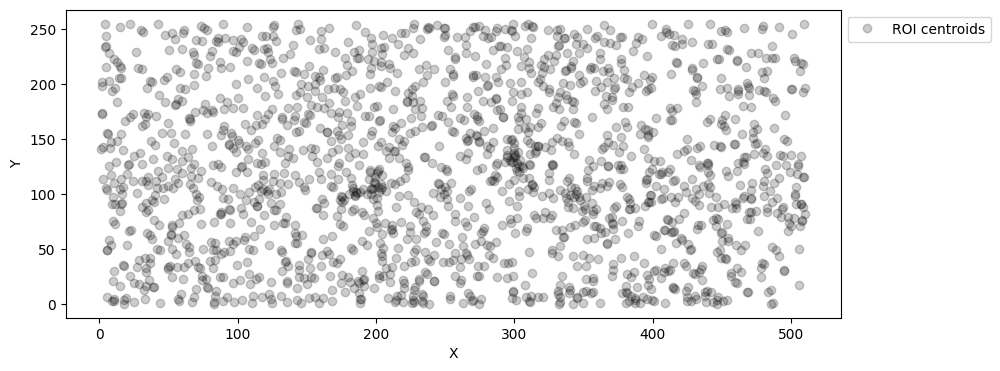

In [75]:
# Calculate centroids for each ROI and plot 

centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.xlabel('X') 
plt.ylabel('Y')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Find the closest ROI to the conditioned neuron 

Let's overlay the conditioned neuron x/y coordinate to our plot of ROI centroids. We assume that the ROI image mask closest to the coordinate is the corresponding ROI for the conditioned neuron. 

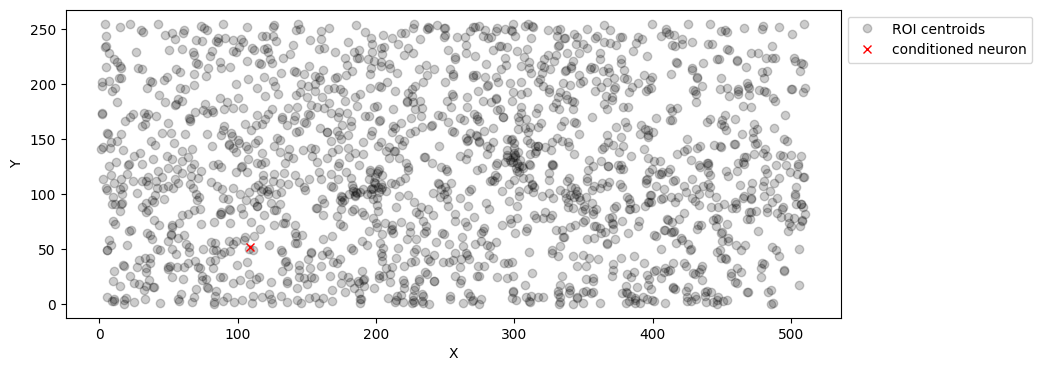

In [76]:
centroids = get_roi_centroids(image_segmentation)
centroidX = centroids[:, 0]
centroidY = centroids[:, 1]

plt.plot(centroidX, centroidY, 'ko', alpha = 0.2, label = 'ROI centroids')
plt.plot(bci['conditioned_neuron_x'].iloc[0], bci['conditioned_neuron_y'].iloc[0], 'rx', alpha = 1, label = 'conditioned neuron')
plt.xlabel('X') 
plt.ylabel('Y')
plt.legend()
plt.legend(bbox_to_anchor=(1.0, 1.0))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We'll calculate the Euclidean distance between each ROI centroid and the conditioned neuron coordinate. The ROI with the minimum distance is our `closest_roi`, in other words, the index in dff that will give us the neural activity trace for the conditioned neuron. 

In [77]:
# Grab the conditioned neuron coordinate 
x = bci['conditioned_neuron_x'].iloc[0]
y = bci['conditioned_neuron_y'].iloc[0]
conditioned_coord = np.array([x, y])
print("Conditioned neuron coordinate:", conditioned_coord)

# Calculate the ROI centroid coordinates 
centroids = get_roi_centroids(image_segmentation)
# Reshape into an array of shape: nROIs, 2 
roi_coords = np.stack((centroids[:, 0], centroids[:, 1]), axis=1)
# Calculate euclidean distance between each ROI coord and conditioned neuron coord, find min 
conditioned_neuron = np.argmin(np.linalg.norm(roi_coords - conditioned_coord, axis=1))
print(f"Closest ROI is #{conditioned_neuron} at {centroids[conditioned_neuron]}")
    

print('Conditioned neuron coordinates:', bci.conditioned_neuron_x[0], bci.conditioned_neuron_y[0])

Conditioned neuron coordinate: [108.63333333  51.66666667]
Closest ROI is #124 at [108.38235294  50.44117647]
Conditioned neuron coordinates: 108.63333333333333 51.666666666666664


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot conditioned neuron activity and behavior events 

Now, we can get the neural activity trace in `dff` for the conditioned neuron and plot this with the behavior information from the bci table. We'll plot the activity of the conditioned neuron aligned to the behavior trial start time, lickport movements, and reward times. 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Convert discrete behavior events into a continuous series 

In [78]:
# Build binary time series

# Initialize timeseries arrays set to 0
n_frames = dff.shape[0]
lickport_steps_ts = np.zeros(n_frames)
rewards_ts = np.zeros(n_frames)
trial_starts_ts = np.zeros(n_frames)

# If behavior event happened, set frame index == 1 
for _, row in bci.iterrows():
    trial_start_f = int(row['start_frame'])

    # Trial start
    if trial_start_f < n_frames:
        trial_starts_ts[trial_start_f] = 1

    # Reward
    rt = row.get('reward_time', np.nan)
    if not np.isnan(rt):
        reward_f = trial_start_f + int(rt * frame_rate)
        if reward_f < n_frames:
            rewards_ts[reward_f] = 1

    # Zaber steps
    zsteps = row.get('zaber_step_times', [])
    if isinstance(zsteps, (list, np.ndarray)):
        for tstep in zsteps:
            if not np.isnan(tstep):
                step_f = trial_start_f + int(tstep * frame_rate)
                if 0 <= step_f < n_frames:
                    lickport_steps_ts[step_f] = 1


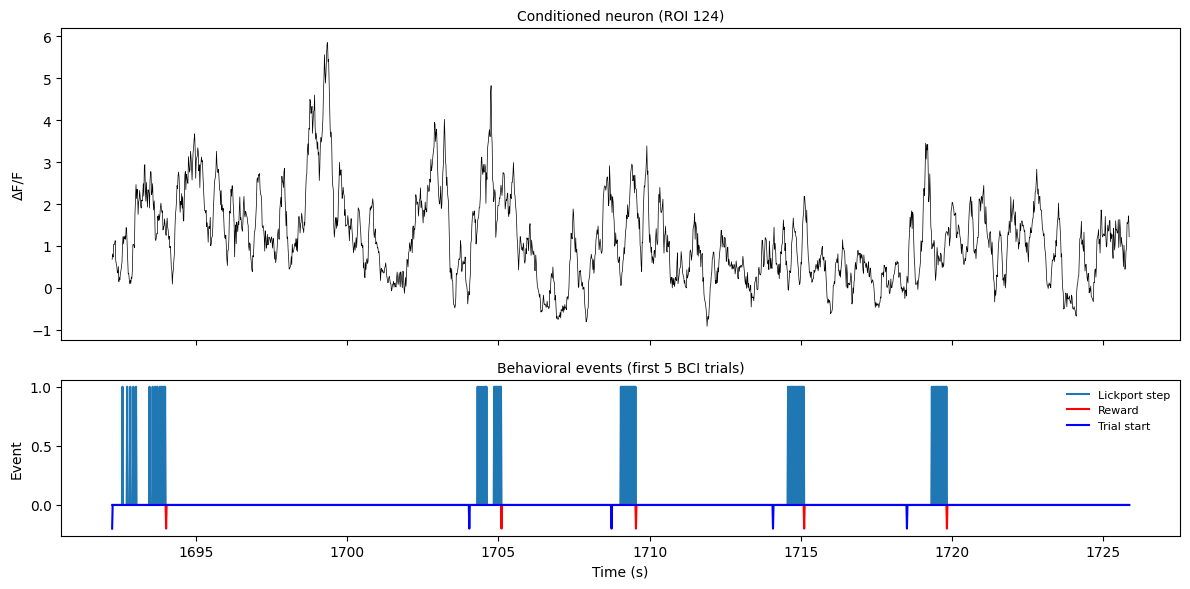

In [79]:
# Set smoothing window size (in frames); set to 0 to disable smoothing
smoothing_window = 10

# Define frame range for first 5 trials
start_f = int(bci['start_frame'].iloc[0])
stop_f  = int(bci['stop_frame'].iloc[4])

# Set bounds for first 5 trials 
frame_range = slice(start_f, stop_f)

# Convert frames to time 
t = np.arange(start_f, stop_f) / frame_rate

# Plot stacked subplots 
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True, height_ratios=[1, 0.5])

# Get conditioned neuron activity over frame_range
trace = dff[frame_range, conditioned_neuron]

# Apply boxcar smoothing if requested
if smoothing_window > 0:
    kernel = np.ones(smoothing_window) / smoothing_window
    trace = np.convolve(trace, kernel, mode='same')

axs[0].plot(t, trace, 'k', linewidth=0.5)

axs[0].set_ylabel('ΔF/F')
axs[0].set_title(f'Conditioned neuron (ROI {conditioned_neuron})', fontsize=10)

# Plot behavioral events 
axs[1].plot(t, lickport_steps_ts[frame_range], label='Lickport step')
axs[1].plot(t, -rewards_ts[frame_range]/5, 'r', label='Reward')
axs[1].plot(t, -trial_starts_ts[frame_range]/5, 'b', label='Trial start')
axs[1].legend(fontsize=8, loc='upper right', frameon=False)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Event')
axs[1].set_title('Behavioral events (first 5 BCI trials)', fontsize=10)

plt.tight_layout()
plt.show()


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
#### Plot photostimulus-aligned neural activity traces 

During the photostimulation epochs of the experiment, random single neurons are selectively photostimulated and targeted using their coordinates in the imaging pixel space. Similar to the conditioned neuron, the x/y coordinates are stored as the`laser_x` and `laser_y` columns of the photostim table. Additionally, each neuron is given a `group_index`: a number identifier that is used track the neurons during experiments. Importantly, the photostim_table also contains a `closest_roi` column that gives us the column index in the dff array for the target neuron.  

In [80]:
photostim.head()

,start_time,stop_time,start_frame,stop_frame,tiff_file,stimulus_name,laser_x,laser_y,power,duration,stimulus_function,group_index,closest_roi
id,,,,,,,,,,,,,
0,0.000000,0.617884,0,36,spont_slm_00001.tif,photostim,241.425926,212.703704,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,78,421
1,0.635047,1.218604,37,71,spont_slm_00002.tif,photostim,168.200000,149.975000,4,0.583557,scanimage.mroi.stimulusfunctions.logspiral,55,355
2,1.235767,1.836487,72,107,spont_slm_00003.tif,photostim,165.013514,133.905405,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,8,153
3,1.853651,2.454371,108,143,spont_slm_00004.tif,photostim,239.032258,40.870968,4,0.600720,scanimage.mroi.stimulusfunctions.logspiral,65,1169
4,2.471534,3.089418,144,180,spont_slm_00005.tif,photostim,57.355556,112.800000,4,0.617884,scanimage.mroi.stimulusfunctions.logspiral,15,85


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot mean response across all ROIs to photostimulation (first 15 trials). 

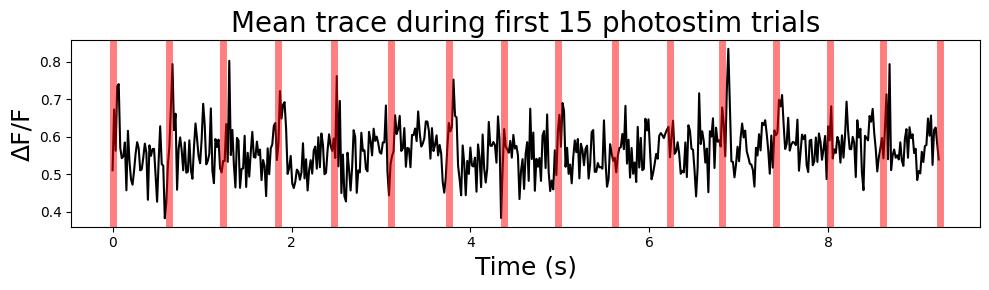

In [81]:
# Initialize plot 
plt.figure(figsize=(10,3))

# Get first 15 photostim events
events = photostim[photostim.stimulus_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values

# Define time window: 2s before first stim to 3s after last
start_f = max(0, stim_frames[0] - int(.2 * frame_rate))
stop_f  = min(len(dff), stim_frames[-1] + int(0 * frame_rate))
t = np.arange(start_f, stop_f) / frame_rate

# Plot average trace during this window
# plt.figure(figsize=(3, 1))
trace = np.nanmean(dff[start_f:stop_f], axis=1)
plt.plot(t, trace, 'k')

# Overlay stim event markers
for f in stim_frames:
    if start_f <= f <= stop_f:
        plt.axvline(f / frame_rate, color='r', alpha=0.5, linewidth = 5 )

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('ΔF/F', fontsize=18)
plt.title('Mean trace during first 15 photostim trials', fontsize=20)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Select a trial and plot the response of the target (photostimulated) neuron

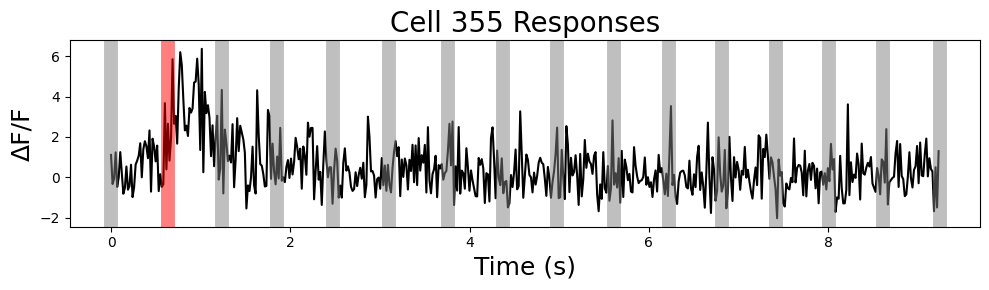

In [82]:
# Initialize variables 
plt.figure(figsize=(10,3))
trial_of_interest = 2 
pre_frames = int(0.2 * frame_rate) # pre-trial frame window
post_frames = int(0 * frame_rate)  # post-trial frame window

# Get the neuron identity of the photostimulated neuron in this trial (dff index) 
cell = photostim.closest_roi[trial_of_interest - 1] 

# Define time window for plotting 
start_f = max(0, stim_frames[0] - pre_frames)
stop_f  = min(len(dff), stim_frames[-1] + post_frames)
t = np.arange(start_f, stop_f) / frame_rate

# Get dff trace for the selected neuron 
trace = dff[start_f:stop_f, cell]
plt.plot(t, trace, 'k')

# Get the photostimulation trial times 
events = photostim[photostim.stimulus_name == 'photostim'].iloc[:16]
stim_frames = events['start_frame'].values

# Plot the photostimulation trial times 
for i, f in enumerate(stim_frames):
    if start_f <= f <= stop_f:
        color = 'gray'
        if i == trial_of_interest - 1:
            color = 'r'
        plt.axvline(f / frame_rate, color=color, alpha=0.5, linewidth=10)

plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('ΔF/F', fontsize=18)
plt.title(f'Cell {cell} Responses', fontsize=20)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot this cell's responses to all photostimulation presentations
    
Note that we are importing the `cell` variable that we identified in the cell above. 

Fstim shape:(60, 1736, 2305)


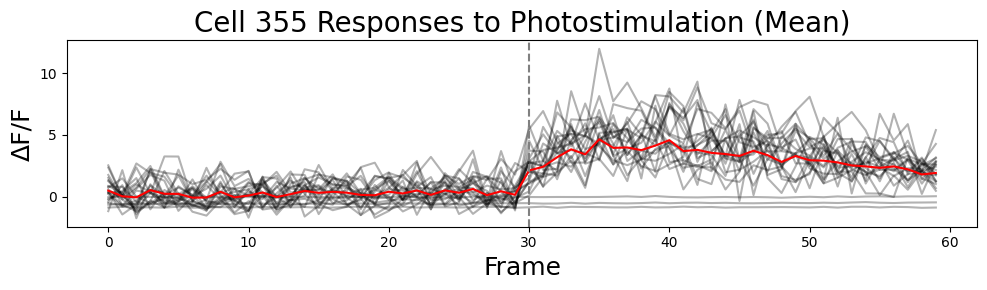

In [83]:
#Initialize variables 
# cell = 0 # uncomment to select a different cell than the one we defined above 
plt.figure(figsize=(10,3))
# Define frame window bins 
pre_frames = 30
post_frames = 30
window_size = pre_frames + post_frames

# Reshape dff into a time window x neuron x trial ndarray 
stim_frames = photostim[photostim.stimulus_name == 'photostim']['start_frame'].values 
n_trials = len(stim_frames)
n_neurons = dff.shape[1]
Fstim = np.full((window_size, n_neurons, n_trials), np.nan)

for k, frame in enumerate(stim_frames):
    if frame - pre_frames < 0 or frame + post_frames >= dff.shape[0]:
        continue
    Fstim[:, :, k] = dff[frame - pre_frames : frame + post_frames, :]
print(f'Fstim shape:{Fstim.shape}')

# Get the photostimulated cell order  
seq = photostim[photostim.stimulus_name == 'photostim']['closest_roi'].values

# Filter Fstim only for trials where targeted neuron was targeted 
trials = np.where(seq == cell)[0]
# Plot single trial responses 
plt.plot(Fstim[:, cell, trials], 'k', alpha=0.3)
# Plot mean photostimulation response
plt.plot(np.nanmean(Fstim[:, cell, trials], axis=1), 'r')
plt.axvline(pre_frames, color='gray', linestyle='--')
plt.title(f'Cell {cell} Responses to Photostimulation (Mean)', fontsize=20)
plt.xlabel('Frame', fontsize=18)
plt.ylabel('ΔF/F', fontsize=18)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

#### Plot group responses to photostimulation across several trials 

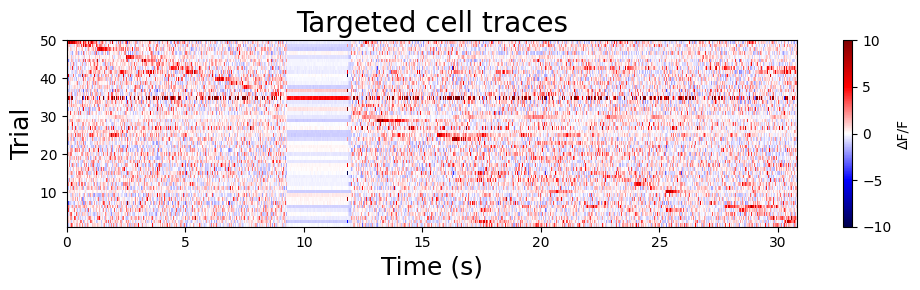

In [84]:
# Initialize variables 
plt.figure(figsize=(10,3))
trials = 50 # define number of photostim trials to plot 
pre_frames = int(0.2 * frame_rate) # pre-trial frame window
post_frames = int(0 * frame_rate)  # post-trial frame window

# Filter photostim dataframe for only the selected trials period 
events = photostim[photostim.stimulus_name == 'photostim'].iloc[:trials]
# Get the start frames for the selected trials 
stim_frames = events['start_frame'].values 
# Get the group index of the targeted neurons 
groups = events['group_index'].values 
# Get the dff index of the targeted neurons 
target_cells = photostim.closest_roi[:len(groups)] 

# Define time window for the selected trials period 
start_f = max(0, stim_frames[0] - pre_frames)
stop_f = min(len(dff), stim_frames[-1] + post_frames)
t = np.arange(start_f, stop_f) / frame_rate

# Reorder dff by the target cell order and grab only within the time window 
traces = np.array([dff[start_f:stop_f, cell] for cell in target_cells])

# Plot as heatmap
plt.imshow(traces, aspect='auto', cmap='seismic', vmin=-10, vmax=10,
           extent=[t[0], t[-1], 1, len(traces)],interpolation = 'none')
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
plt.title('Targeted cell traces', fontsize=20)
plt.colorbar(label='ΔF/F')
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; ">

#### Questions and analyses to explore further:
 
* How does connectivity change across the photostimulation periods? Does it change with the BCI task? 
    
* How does connection strength depend on distance? 
    
* Do correlated neurons tend to have stronger connections? 
    
* Quantify the degree to which the conditioned neuron increases its activity throughout the task. 
    
* Do differences in the transgenic lines or injected viruses impact connectivity and photostimulation measurements? 
    
* Do non-conditioned neurons change activity during the BCI task? 
    